In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

EJERCICIO 1

In [3]:
def impulsivo(val0,prob0,val1,prob1,val2,size):
    arr = np.zeros(size)
    n_ib = cv.randu(arr,0,1)
    for i in np.arange(size[0]):
        for j in np.arange(size[1]):
            if n_ib[i,j] <=prob0:
                n_ib[i,j] = val0
            elif n_ib[i,j]>prob0 and n_ib[i,j]<prob0+prob1:
                n_ib[i,j] = val1
            else:
                n_ib[i,j] = val2
    return n_ib

def mse(imageA, imageB): 
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) 
    err /= float(imageA.shape[0] * imageA.shape[1]) 
    return err

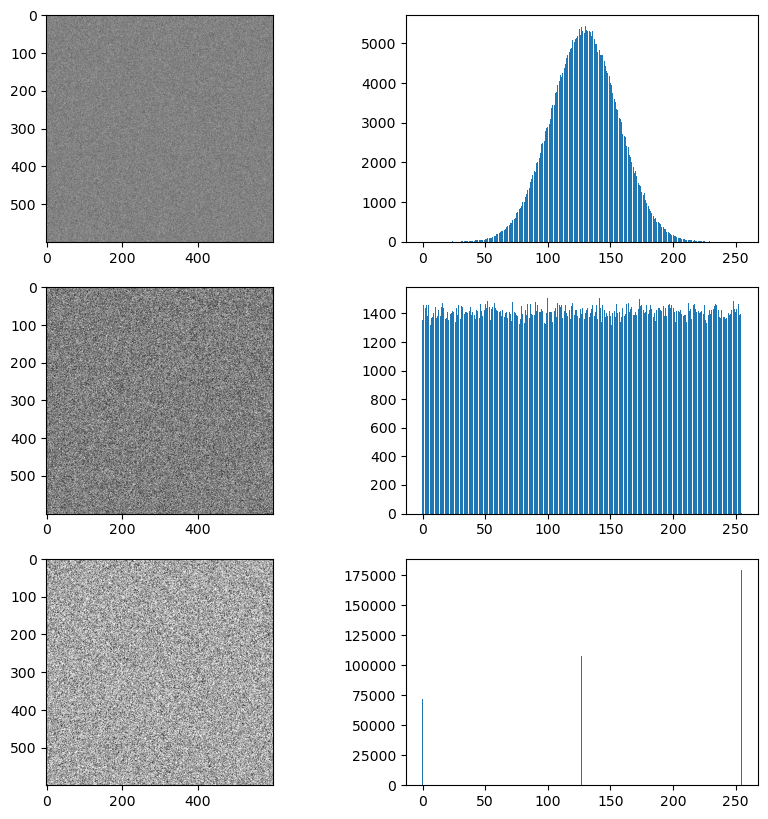

In [4]:
#gaussian noise
im0 = np.zeros((600,600))
n_g = cv.randn(np.copy(im0),100,10)
n_g_n = np.uint8(cv.normalize(np.copy(n_g),np.copy(n_g), 0, 255, cv.NORM_MINMAX))

#uniform noise
n_u = cv.randu(np.copy(im0),-5,5)
n_u_n = np.uint8(cv.normalize(np.copy(n_u),np.copy(n_u), 0, 255, cv.NORM_MINMAX))

#salt and pepper
n_sp = impulsivo(0,.2,255,.5,127,im0.shape)

#histograms
hist_n_g_n = cv.calcHist([n_g_n], [0], None, [256], [0,256])
hist_n_u_n = cv.calcHist([n_u_n], [0], None, [256], [0,256])
hist_n_sp = cv.calcHist([np.uint8(n_sp)], [0], None, [256], [0,256])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10)) 
ax[0,1].bar(range(256),np.squeeze(hist_n_g_n))
ax[0,0].imshow(n_g_n,cmap='gray',vmin=0,vmax=255)

ax[1,1].bar(range(256),np.squeeze(hist_n_u_n))
ax[1,0].imshow(n_u_n,cmap='gray',vmin=0,vmax=255)

ax[2,1].bar(range(256),np.squeeze(hist_n_sp))
ax[2,0].imshow(n_sp,cmap='gray',vmin=0,vmax=255)
plt.show()

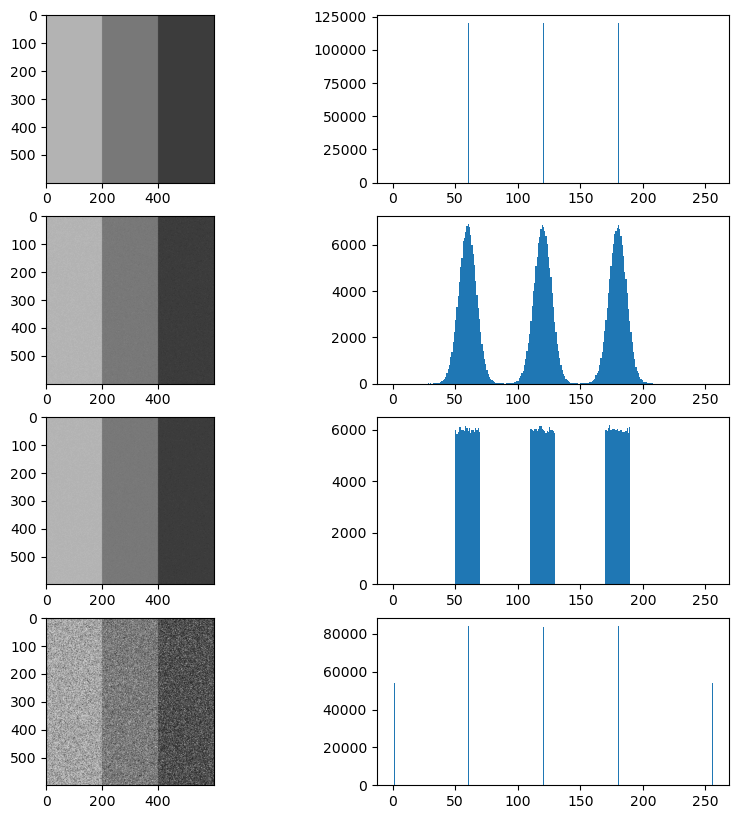

In [5]:
im1 = np.zeros((600,600))
im1[:,0:200] = 180
im1[:,200:400] = 120
im1[:,400:600] = 60

#noising
im1_n_g_n = im1 + np.random.normal(0, 7, (im1.shape[0],im1.shape[1]))
im1_n_u_n = im1 + np.random.uniform(-10,10, (im1.shape[0],im1.shape[1]))
n_i = impulsivo(1,.15,255,.15,0,im1.shape)
im1_n_sp = np.where(n_i > 0, n_i, im1)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(im1,cmap='gray',vmin=0,vmax=255)
ax[0,1].hist(im1.ravel(),256,[0,256])

ax[1,0].imshow(im1_n_g_n,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(im1_n_g_n.ravel(),256,[0,256])

ax[2,0].imshow(im1_n_u_n,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(im1_n_u_n.ravel(),256,[0,256])

ax[3,0].imshow(im1_n_sp,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(im1_n_sp.ravel(),256,[0,256])
plt.show()

EJERCICIO 2

In [6]:
def geometric_mean_filter(image, filter_size):
    # Obtener el tamaño de la imagen
    im_H, im_W = image.shape
    #aplica filtro media geométrica, im -> im_f_mg
    filter_size = 3
    padsize = (filter_size-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,1).astype(np.float64)

    im_f_mg = np.zeros(image.shape)

    for i in range(im_H):
        for j in range(im_W):
            im_f_mg[i, j] = np.prod(im_p[i:i+filter_size,j:j+filter_size])**(1/(filter_size**2))

    return im_f_mg

def contrarmonic_filter(image, ksize,Q):

    # Obtener el tamaño de la imagen
    im_H, im_W = image.shape

    ksize = 3
    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)

    im_f_mch = np.zeros(image.shape)
    for i in range(im_H):
        for j in range(im_W):
            im_f_mch[i, j] = np.sum(im_p[i:i+ksize,j:j+ksize]**(Q+1))/(np.sum(im_p[i:i+ksize,j:j+ksize]**Q))

    return im_f_mch

MSE Degradada (Gauss) - Limpia:  383.2255583333333
MSE Filtrada (GeoMean) - Limpia:  301.01274229435853


MSE Degradada (Imp) - Limpia:  1364.2593541666668
MSE Filtrada (ContArm) - Limpia:  843.0707650917662


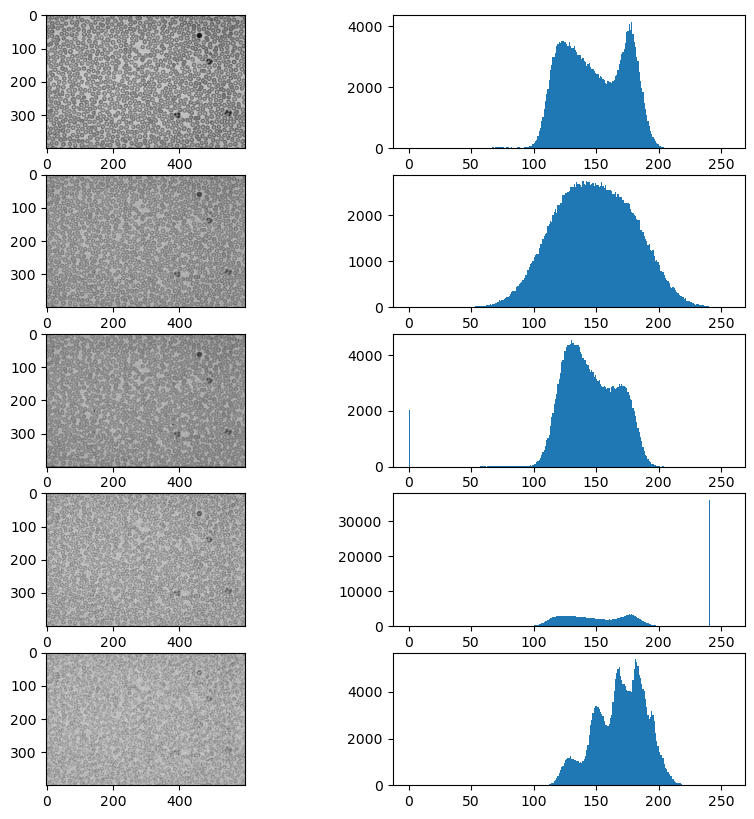

In [7]:
sangre = cv.imread('imagenes/sangre.jpg', cv.IMREAD_GRAYSCALE)

gaussian = np.random.normal(0, 20, (sangre.shape[0],sangre.shape[1])).astype(np.uint8)
imp_noise = impulsivo(50,0,240,0.15,0,sangre.shape).astype(np.uint8)

sangre_noise_g = sangre+gaussian
sangre_noise_imp = np.where(imp_noise > 0,imp_noise,sangre)
sangre_filtrada = geometric_mean_filter(sangre_noise_g,3)

sangre_filtrada_2 = contrarmonic_filter(sangre_noise_imp,3,1)

print("MSE Degradada (Gauss) - Limpia: ",mse(sangre,sangre_noise_g))
print("MSE Filtrada (GeoMean) - Limpia: ",mse(sangre,sangre_filtrada))
print("\n")
print("MSE Degradada (Imp) - Limpia: ",mse(sangre,sangre_noise_imp))
print("MSE Filtrada (ContArm) - Limpia: ",mse(sangre,sangre_filtrada_2))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(sangre,cmap='gray')
ax[0,1].hist(sangre.ravel(),256,[0,256])

ax[1,0].imshow(sangre_noise_g,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(sangre_noise_g.ravel(),256,[0,256])

ax[2,0].imshow(sangre_filtrada,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(sangre_filtrada.ravel(),256,[0,256])

ax[3,0].imshow(sangre_noise_imp,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(sangre_noise_imp.ravel(),256,[0,256])

ax[4,0].imshow(sangre_filtrada_2,cmap='gray',vmin=0,vmax=255)
ax[4,1].hist(sangre_filtrada_2.ravel(),256,[0,256])
plt.show()


# ejercicio 3

In [114]:
def punto_medio(image, ksize):
    im_H, im_W = image.shape
    im_f_mch = np.zeros(image.shape)

    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)
    
    im_f_pm0 = np.zeros(image.shape)
    for i in range(im_H):
        for j in range(im_W):
            vMin, vMax = cv.minMaxLoc(im_p[i:i+ksize,j:j+ksize])[0:2]
            im_f_pm0[i, j] = (vMin+vMax)/2
    return im_f_pm0

def media_alfa(im, ksize):
    #aplica filtro media-alfa recortado
    #ksize = 3
    im_H, im_W = im.shape
    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(im), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)
    im_f_mar = np.zeros(im.shape)

    #0<=d<=mn-1, mn -> tamaño del "kernel"
    d = 8
    for i in range(im_H):
        for j in range(im_W):
            S = np.sort(im_p[i:i+ksize,j:j+ksize].flatten())
            S = S[d//2:S.shape[0]-d//2]
            im_f_mar[i, j] = np.sum(S)/S.shape[0]
    return im_f_mar


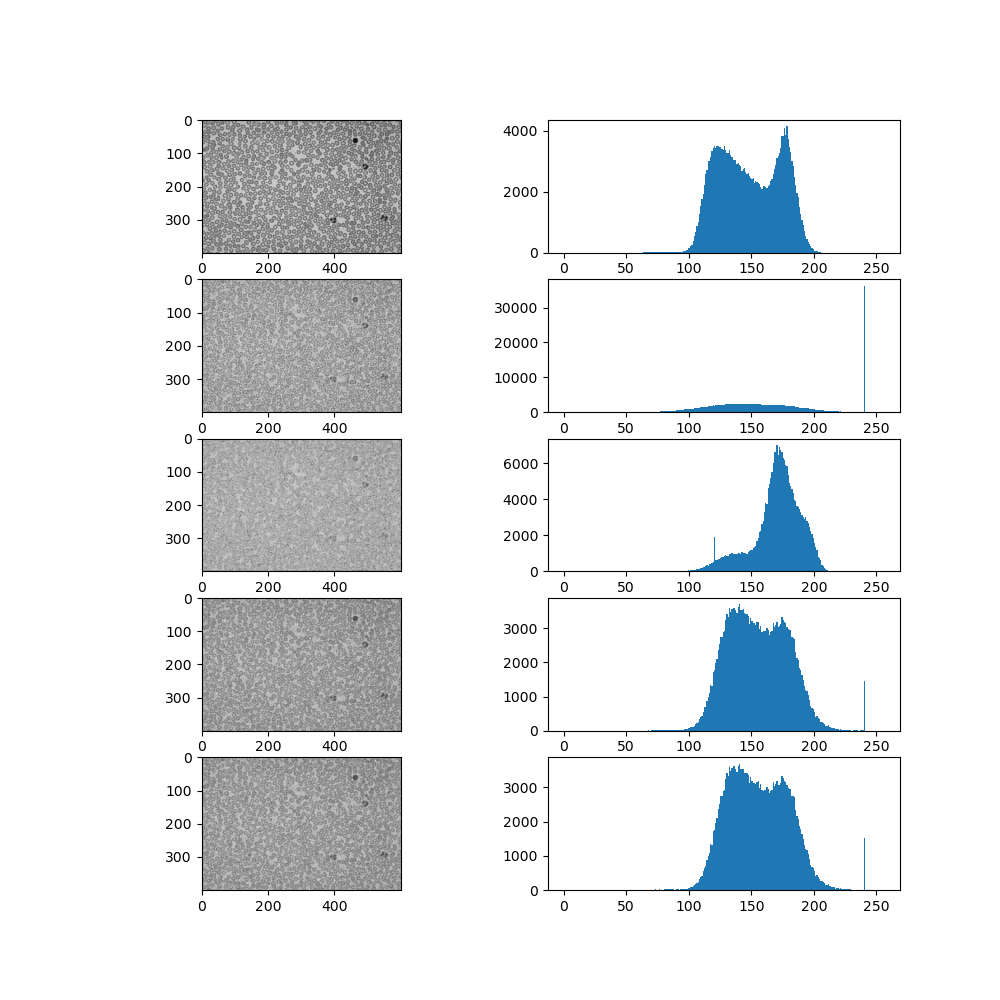

In [118]:
sangre = cv.imread('imagenes/sangre.jpg', cv.IMREAD_GRAYSCALE)

sangre_noise_g = sangre+gaussian
sangre_noise_imp = np.where(imp_noise > 0,imp_noise,sangre_noise_g)

sangre_ptomedio = punto_medio(sangre_noise_imp, 3)
sangre_medalfa = media_alfa(sangre_noise_imp, 3)
sangre_median = cv.medianBlur(sangre_noise_imp , 3)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(sangre,cmap='gray')
ax[0,1].hist(sangre.ravel(),256,[0,256])

ax[1,0].imshow(sangre_noise_imp,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(sangre_noise_imp.ravel(),256,[0,256])

ax[2,0].imshow(sangre_ptomedio,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(sangre_ptomedio.ravel(),256,[0,256])

ax[3,0].imshow(sangre_medalfa,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(sangre_medalfa.ravel(),256,[0,256])

ax[4,0].imshow(sangre_median,cmap='gray',vmin=0,vmax=255)
ax[4,1].hist(sangre_median.ravel(),256,[0,256])
plt.show()


# ejercicio 5

In [76]:
from __future__ import division
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.stats
import math


def optimalDFTImg(img):
    """Zero-padding sobre img para alcanzar un tamaño óptimo para FFT"""
    h=cv.getOptimalDFTSize(img.shape[0])
    w=cv.getOptimalDFTSize(img.shape[1])
    return cv.copyMakeBorder(img,0,h-img.shape[0],0,w-img.shape[1],cv.BORDER_CONSTANT)

def spectrum(img):
    """Calcula y muestra el módulo logartímico de la DFT de img."""
    #img=optimalDFTImg(img)
    
    imgf=cv.dft(np.float32(img),flags=cv.DFT_COMPLEX_OUTPUT) 
    modulo = np.log(cv.magnitude(imgf[:,:,0],imgf[:,:,1])+1)
    modulo = np.fft.fftshift(modulo) 
    modulo=cv.normalize(modulo, modulo, 0, 1, cv.NORM_MINMAX)
    
    return modulo
    # plt.figure()
    # plt.imshow(modulo,cmap='gray')
    # plt.show()

def rotate(img,angle):
    """Rotación de la imagen sobre el centro"""
    r=cv.getRotationMatrix2D((img.shape[0]/2,img.shape[1]/2),angle,1.0)
    return cv.warpAffine(img,r,img.shape)

def filterImg(img,filtro_magnitud):
    """Filtro para imágenes de un canal"""
    
    
    #como la fase del filtro es 0 la conversión de polar a cartesiano es directa (magnitud->x, fase->y)
    filtro=np.array([filtro_magnitud,np.zeros(filtro_magnitud.shape)]).swapaxes(0,2).swapaxes(0,1)
    imgf=cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
   
    imgf=cv.mulSpectrums(imgf, np.float32(filtro), cv.DFT_ROWS)
    
    return cv.idft(imgf, flags=cv.DFT_REAL_OUTPUT | cv.DFT_SCALE)



def dist(a,b):
    """distancia Euclidea"""
    return np.linalg.norm(np.array(a)-np.array(b))

def filterGaussian(rows,cols,corte):
    """Filtro de magnitud gausiano"""

    magnitud = np.zeros((rows, cols))

    corte *= rows
    for k in range(rows):
        for l in range(cols):
            magnitud[k,l]=np.exp(-dist([k+.5,l+.5],[rows/2,cols/2])/2/corte/corte)
            
    return np.fft.fftshift(magnitud)
    
        
def filterIdeal(rows, cols, corte):
    """filtro de magnitud ideal"""
    magnitud = np.zeros((rows, cols))
    if cols%2==1 and rows%2==1: #impar, el centro cae en un píxel
        print('entro')
        magnitud=cv.circle(magnitud, (cols/2,rows/2), rows*corte, 1, -1)
    else:
        limit = (corte*rows)**2
        for k in range(rows):
            for l in range(cols):
                d2 = dist([k+.5,l+.5],[rows/2,cols/2])
                if d2 <= limit: 
                    magnitud[k,l] = 1
    return np.fft.fftshift(magnitud)

	
def filterButterworth(rows, cols, corte, order):
    """filtro de magnitud Butterworth"""
    #corte = w en imagen de lado 1
    #1 \over 1 + {D \over w}^{2n}
    magnitud = np.zeros((rows, cols))
    corte *= rows;
    for k in range(rows):
        for l in range(cols):
            d2 = dist([k+.5,l+.5],[rows/2,cols/2])
            magnitud[k,l] = 1.0/(1 + (d2/corte/corte)**order)

    return np.fft.fftshift(magnitud)

def filterButterworth2(rows, cols,r_center,c_center, corte, order):
    """filtro de magnitud Butterworth"""
    #corte = w en imagen de lado 1
    #1 \over 1 + {D \over w}^{2n}
    magnitud = np.zeros((rows, cols))
    corte *= rows;
    for k in range(rows):
        for l in range(cols):
            d2 = dist([k+.5,l+.5],[r_center,c_center])
            magnitud[k,l] = 1.0/(1 + (d2/corte/corte)**order)

    return magnitud

    
def motionBlur(size, a,  b):
    """Filtro de movimiento en direcciones a y b"""
    transformation =np.zeros(size)
    rows = size[0]
    cols = size[1]

    #fase exp(j\pi (ua + vb))
    #magnitud \frac{ \sin(\pi(ua+vb)) }{ \pi (ua+vb) }
    for k in range(rows):
        for l in range(cols):
            u = (l-cols/2)/cols
            v = (k-rows/2)/rows

            pi_v = math.pi*(u*a+v*b);
            if pi_v:
                mag = np.sin(pi_v)/pi_v
            else:
                mag=1 #lim{x->0} sin(x)/x
            
            transformation[k,l] = mag*np.exp(complex(0,1)*pi_v);
			

    return np.fft.fftshift(transformation)


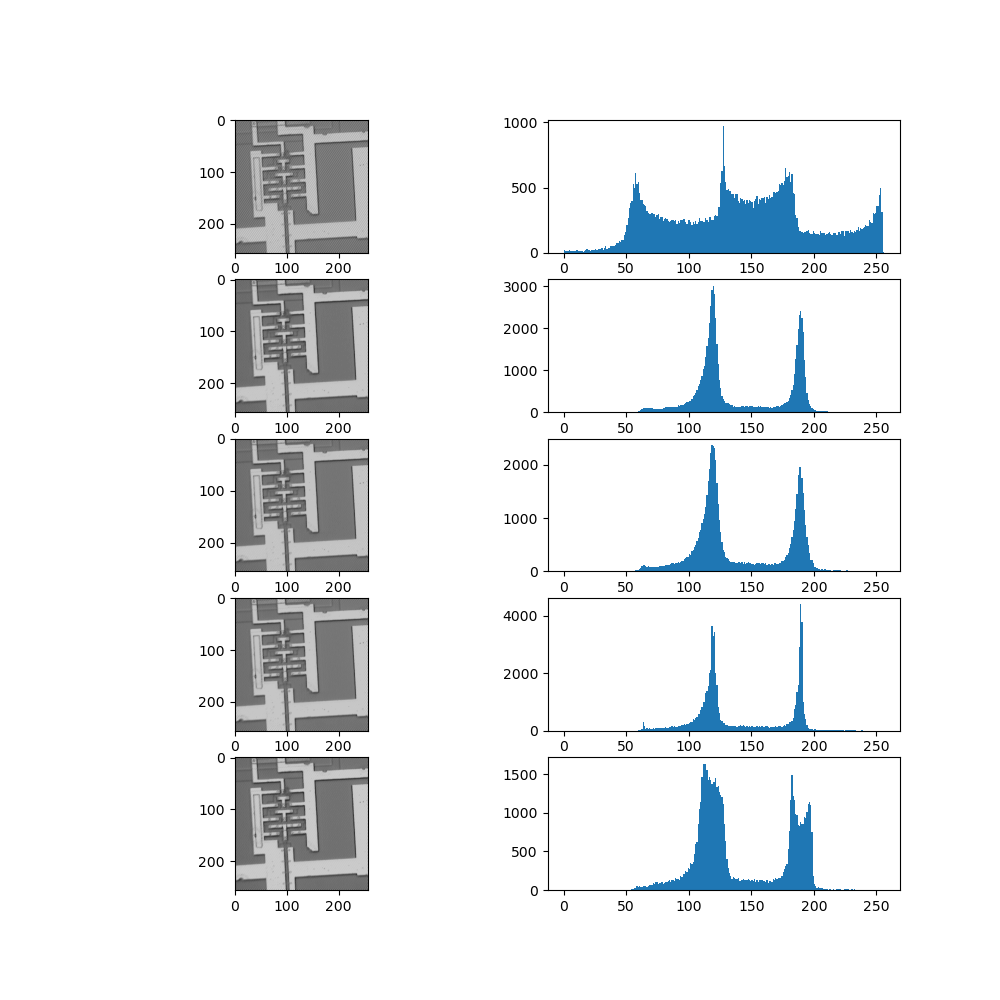

MSE Degradada (original) - Limpia:  3522.132110595703
MSE Filtrada (rechaza banda) - Limpia:  1546.2529961078637
MSE Degradada (notch lineal) - Limpia:  1576.1725018645884
MSE Filtrada (butter) - Limpia:  1563.2323288502657
MSE Filtrada (butter notch) - Limpia:  1561.889969909183


In [95]:
%matplotlib widget
im0 = cv.imread('imagenes/img_degradada.tif', cv.IMREAD_GRAYSCALE)
im = cv.imread('imagenes/img.tif', cv.IMREAD_GRAYSCALE)


im0_H, im0_W = im0.shape
rechaza_banda = filterIdeal(im0_H,im0_W,.040) + filterIdeal(im0_H,im0_W,.043)
rechaza_banda=np.abs(1-rechaza_banda)
im_rechaza_banda = filterImg(im0,rechaza_banda)


fft_im0 = spectrum(im0)
dlt = 25
fft_im0[im0_H//2-dlt:im0_H//2+dlt,im0_W//2-dlt:im0_W//2+dlt] = 0
fft_shift_im0 = np.fft.fftshift(fft_im0)
x0,y0 = cv.minMaxLoc(fft_shift_im0)[3]


copy1 = np.zeros((im0_H,im0_W))
copy1 = cv.circle(copy1, (x0,y0), 6, 1, -1)
copy1 = cv.circle(copy1, (copy1.shape[0]-x0,copy1.shape[1]-y0), 6, 1, -1)
copy1 = np.abs(1-copy1)
im_notch_lineal = filterImg(im0,copy1)

butter = filterButterworth(im0_H,im0_W,.04,20) + filterButterworth(im0_H,im0_W,.043,20)
butter = np.abs(1-butter)
im_butter = filterImg(im0,butter)


notch_butter = filterButterworth2(im0_H,im0_W,y0,x0,.01,5) + filterButterworth2(im0_H,im0_W,im0_H-y0,im0_W-x0,.01,5) 
notch_butter = np.abs(1-notch_butter)
im_notch_butter = filterImg(im0,notch_butter)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(im0,cmap='gray')
ax[0,1].hist(im0.ravel(),256,[0,256])

ax[1,0].imshow(im_rechaza_banda,cmap='gray')
ax[1,1].hist(im_rechaza_banda.ravel(),256,[0,256])

ax[2,0].imshow(im_notch_lineal,cmap='gray')
ax[2,1].hist(im_notch_lineal.ravel(),256,[0,256])

ax[3,0].imshow(im_notch_butter,cmap='gray')
ax[3,1].hist(im_notch_butter.ravel(),256,[0,256])

ax[4,0].imshow(im_butter,cmap='gray')
ax[4,1].hist(im_butter.ravel(),256,[0,256])
plt.show()

print("MSE Degradada (original) - Limpia: ",mse(im,im0))
print("MSE Filtrada (rechaza banda) - Limpia: ",mse(im,im_rechaza_banda))
print("MSE Degradada (notch lineal) - Limpia: ",mse(im,im_notch_lineal))
print("MSE Filtrada (butter) - Limpia: ",mse(im,im_butter))
print("MSE Filtrada (butter notch) - Limpia: ",mse(im,im_notch_butter))

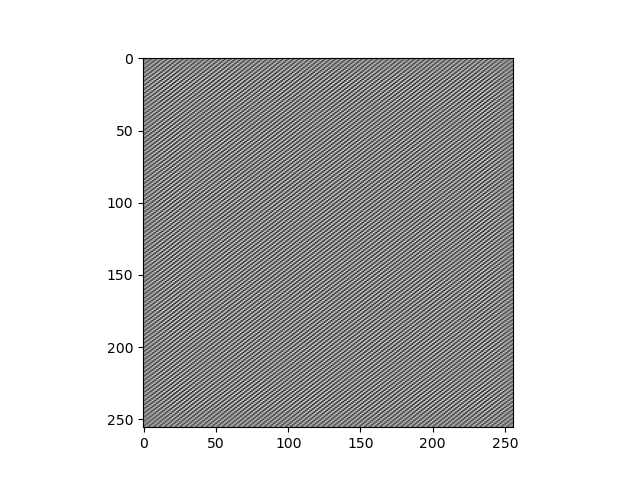

In [97]:
copy1= np.abs(1-copy1)
solo_ruido = filterImg(im0,copy1)
plt.figure()
plt.imshow(solo_ruido,cmap='gray')
plt.show()

# ejercicio 7


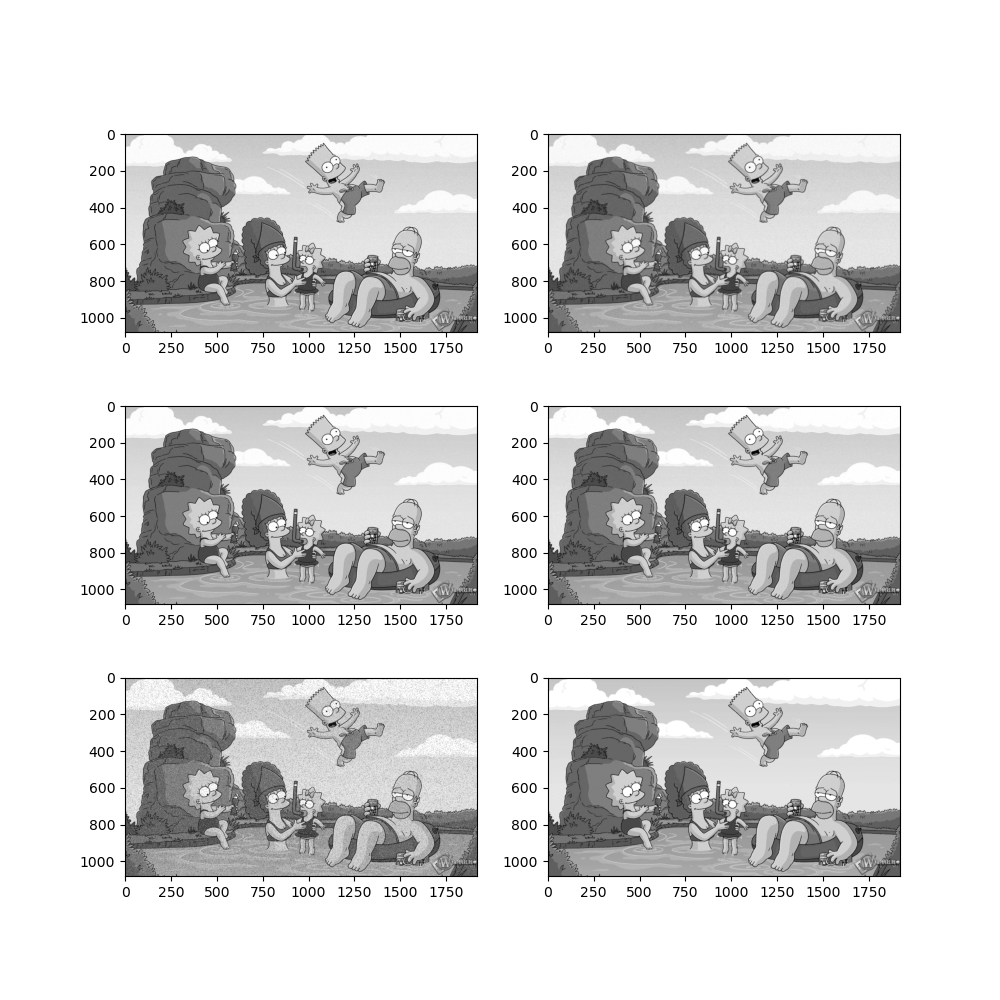

In [126]:
FAMILIA_a = cv.imread('imagenes/FAMILIA_a.jpg', cv.IMREAD_GRAYSCALE)
FAMILIA_b = cv.imread('imagenes/FAMILIA_b.jpg', cv.IMREAD_GRAYSCALE)
FAMILIA_c = cv.imread('imagenes/FAMILIA_c.jpg', cv.IMREAD_GRAYSCALE)

H,W = FAMILIA_a.shape
FAMILIA_a_filtrada= punto_medio(FAMILIA_a, 3)
FAMILIA_b_filtrada = media_alfa(FAMILIA_b, 3)
FAMILIA_c_filtrada = cv.medianBlur(FAMILIA_c,3)
# fam_butter = filterButterworth(H,W,.04,20)
# fam_butter = np.abs(1-butter)
# FAMILIA_a_filtrada = filterImg(FAMILIA_a,fam_butter)


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(FAMILIA_a,cmap='gray')
ax[0,1].imshow(FAMILIA_a_filtrada,cmap='gray')

ax[1,0].imshow(FAMILIA_b,cmap='gray')
ax[1,1].imshow(FAMILIA_b_filtrada,cmap='gray')

ax[2,0].imshow(FAMILIA_c,cmap='gray')
ax[2,1].imshow(FAMILIA_c_filtrada,cmap='gray')